<a href="https://colab.research.google.com/github/dansarmiento/MachineLearning/blob/main/Hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ANOVA**

analysis of variance is a group of statistical techniques that test the difference of means among three or more groups.  

In this notebook, we will look at an example dataset  for marketing and sales and run a one-way ANOVA and a post hoc ANOVA.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
# The data is in google sheets and the spreadsheet can be imported to a dataframe by passing the sheet identifiers in to a url like this

#  https://docs.google.com/spreadsheets/d/1vsDrTCRGDYNs6SlE0wc5pKkmT7lbBLf95ktD1obYGuo/edit?usp=sharing
sheet_id = "1vsDrTCRGDYNs6SlE0wc5pKkmT7lbBLf95ktD1obYGuo"
sheet_name = "Sheet1"

gsheet_url = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(sheet_id,sheet_name)
df = pd.read_csv(gsheet_url)
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tv,radio,social_media,influencer,sales
0,Low,1.218354,1.270444,Micro,90.05422
1,Medium,14.949790,0.274451,Macro,222.74170
2,Low,10.377260,0.061984,Mega,102.77480
3,High,26.469270,7.070945,Micro,328.23940
4,High,36.876300,7.618605,Mega,351.80730


Features in the data include:
- tv promo budget
- social media promo budget
- radio promo budget
- sales
- influencer size

In the exploratory data analysis, we want to look at the distribution of the data, plot the relationship between the independent and dependent variables, and identify any issues

<Axes: xlabel='tv', ylabel='sales'>

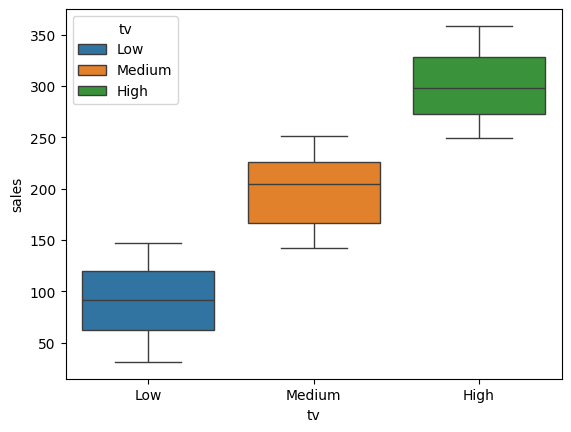

In [ ]:
sns.boxplot(x='tv',y='sales',data=df, hue='tv')
# appears to be a linear relationship

<Axes: xlabel='influencer', ylabel='sales'>

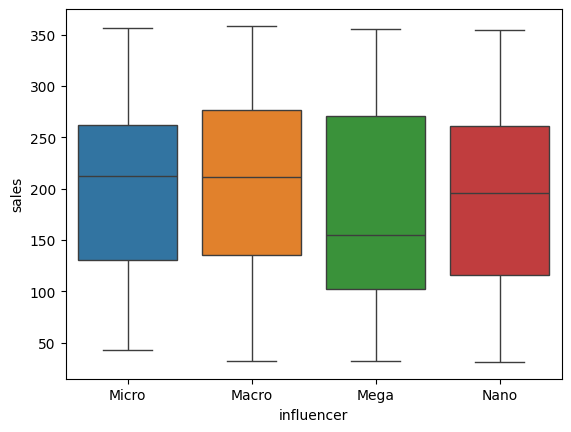

In [ ]:
sns.boxplot(x='influencer',y='sales', data=df, hue='influencer')
# influencer does not appear to have an effect on sales

In [ ]:
# clean the data
df.dropna(axis=0, inplace=True)
df.isnull().sum(axis=0)

,0
tv,0
radio,0
social_media,0
influencer,0
sales,0


In [ ]:
# will fit a linear regression model that predicts sales using one of the independent categorical variables

ols_formula = 'sales ~ C(tv)'
model = ols(formula=ols_formula, data=df).fit()
model_results = model.summary()
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1971.
Date:                Fri, 09 May 2025   Prob (F-statistic):          8.81e-256
Time:                        16:42:52   Log-Likelihood:                -2778.9
No. Observations:                 569   AIC:                             5564.
Df Residuals:                     566   BIC:                             5577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         300.5296      2.417    124.360      0.000     295.783     305.276
C(tv)[T.Low]     -208.8133      3.329    -62.720      0.000    -215.353    -202.274
C(tv)[T.Medium]  -101.5061      3.325    -30.526      0.000    -108.038     -94.975
==============================================================================
Omnibus:                      450.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.763
Skew:                          -0.044   Prob(JB):                     1.71e-08
Kurtosis:                       1.775   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

🧠 Key Takeaways from the Output
🔍 Model Fit
R-squared = 0.874: About 87.4% of the variation in sales is explained by the TV ad level. That’s a very strong relationship.

F-statistic = 1971, p-value ≈ 0: This confirms the model is statistically significant overall (the TV levels do impact sales).

📊 Coefficients Table
Term	Coef.	Meaning
Intercept (300.53)	Average sales when TV ad level is High (baseline group)
C(tv)[T.Low] (-208.81)	Sales drop by ~209 units when ads are Low compared to High
C(tv)[T.Medium] (-101.51)	Sales drop by ~102 units when ads are Medium compared to High

All p-values (P>|t|) are 0.000, meaning these differences are statistically significant.

⚠️ Other Stats
Durbin-Watson = 2.002: No autocorrelation in the residuals (good).

Omnibus, JB, Skew, Kurtosis: Residuals may not be perfectly normally distributed, but for many practical purposes, that’s acceptable if the model fits well.
✅ Conclusion
Your model strongly suggests that reducing TV advertising significantly reduces sales. If your TV ads drop from High to:

Medium → expect a ~102 unit drop in sales.

Low → expect a ~209 unit drop.

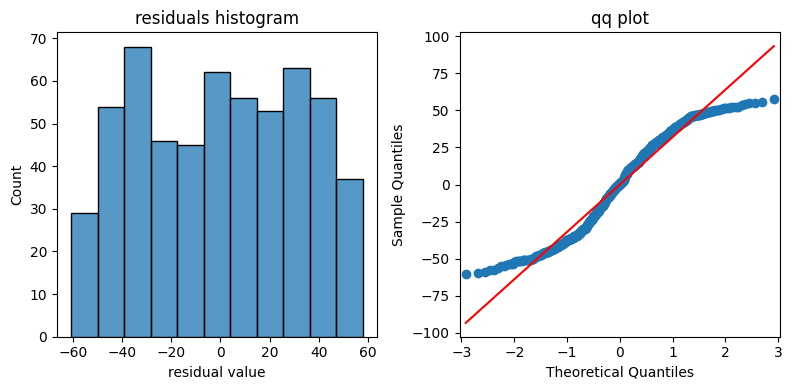

In [ ]:
# checking linearity

residuals = model.resid
fig, axes = plt.subplots(1,2,figsize=(8,4,))
sns.histplot(residuals, ax=axes[0])
axes[0].set_xlabel('residual value')
axes[0].set_title('residuals histogram')

sm.qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title('qq plot')
plt.tight_layout()
plt.show()

There is reasonable concern that normality assumption is not met when TV is used, the qq forms as S that deviates from the diagonal line, but we will proceed anyways to find out what happens when assumptions are violated

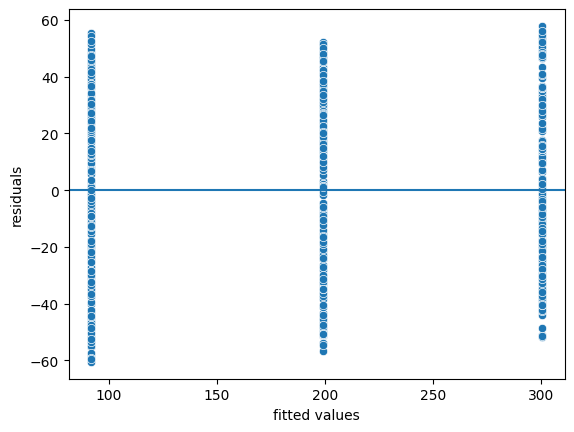

In [ ]:
# evaluation of homoscedasticity

fig = sns.scatterplot(x=model.fittedvalues, y=model.resid)
fig.set_xlabel('fitted values')
fig.set_ylabel('residuals')
fig.axhline(y=0)
plt.show()

the variance where there are fitted values is similarly distributed, validating constant variance

In [ ]:
# one way ANOVA will determine if there is a statistically significant difference among groups

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(tv),4.052692e+06,2.0,1971.455631,8.805667e-256
Residual,5.817589e+05,566.0,NaN,NaN


The null hypothesis is that there is no difference in sales based on tv promo budget, the alternative is that there is.

the F-test statistic is 1971.46 and the p-value is very small.  Because the p-value is less than 0.05, we will reject the null hypothesis and see that tv budget investment is significant


In [ ]:
# anova post hoc test such as Tukey's HSD compares if there is a significant difference between each pair of categories

tukey_oneway = pairwise_tukeyhsd(endog=df['sales'], groups = df['tv'])
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
High,Low,-208.8133,0.0,-216.6367,-200.9898,True
High,Medium,-101.5061,0.0,-109.3202,-93.6921,True
Low,Medium,107.3072,0.0,99.7066,114.9077,True


The first row comparing the high and low ggroups indicates that you can reject the null hypothesis and this is the same for each of the comparisons